In [131]:
import argparse
import os.path as osp
import sys, os

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv

In [132]:
sys.argv = ['-f']
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, required=False, default='Cora')
parser.add_argument('--hidden_channels', type=int, default=16)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--use_gdc', action='store_true', help='Use GDC')
parser.add_argument('--wandb', action='store_true', help='Track experiment')
sys.argv = ['-f']
args = parser.parse_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
init_wandb(name=f'GCN-{args.dataset}', lr=args.lr, epochs=args.epochs,
           hidden_channels=args.hidden_channels, device=device)

In [133]:
path = osp.join(osp.dirname(osp.realpath("__file__")), '', 'data', 'Planetoid')
dataset = Planetoid(path, args.dataset, transform=T.NormalizeFeatures())
data = dataset[0]

In [120]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
data = dataset[0]

In [134]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


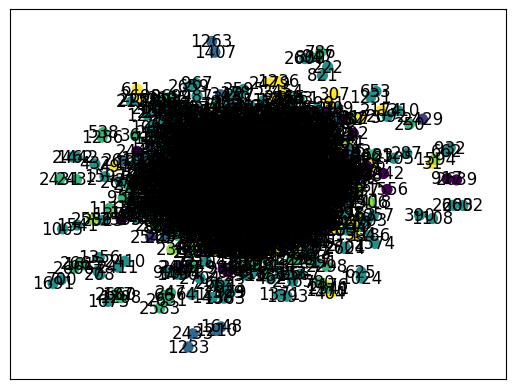

In [135]:
import networkx as nx
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, iterations=13, seed=42), with_labels=True, node_color=data.y, node_size=50, edge_color="black")

In [136]:
if args.use_gdc:
    transform = T.GDC(
        self_loop_weight=1,
        normalization_in='sym',
        normalization_out='col',
        diffusion_kwargs=dict(method='ppr', alpha=0.05),
        sparsification_kwargs=dict(method='topk', k=128, dim=0),
        exact=True,
    )
    data = transform(data)

In [137]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=not args.use_gdc)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=not args.use_gdc)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [138]:
model = GCN(dataset.num_features, args.hidden_channels, dataset.num_classes)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=args.lr)  # Only perform weight-decay on first convolution.

In [139]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [140]:
best_val_acc = final_test_acc = 0
for epoch in range(1, args.epochs + 1):
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)

Epoch: 001, Loss: 1.9452, Train: 0.2214, Val: 0.1540, Test: 0.1550
Epoch: 002, Loss: 1.9409, Train: 0.4214, Val: 0.3160, Test: 0.3200
Epoch: 003, Loss: 1.9342, Train: 0.6500, Val: 0.4520, Test: 0.4630
Epoch: 004, Loss: 1.9252, Train: 0.7000, Val: 0.4940, Test: 0.5040
Epoch: 005, Loss: 1.9164, Train: 0.6786, Val: 0.4560, Test: 0.5040
Epoch: 006, Loss: 1.9045, Train: 0.6571, Val: 0.4320, Test: 0.5040
Epoch: 007, Loss: 1.8972, Train: 0.7143, Val: 0.4520, Test: 0.5040
Epoch: 008, Loss: 1.8923, Train: 0.7214, Val: 0.4740, Test: 0.5040
Epoch: 009, Loss: 1.8739, Train: 0.7214, Val: 0.5120, Test: 0.4920
Epoch: 010, Loss: 1.8559, Train: 0.7286, Val: 0.5200, Test: 0.5130
Epoch: 011, Loss: 1.8454, Train: 0.7643, Val: 0.5380, Test: 0.5370
Epoch: 012, Loss: 1.8361, Train: 0.7786, Val: 0.5580, Test: 0.5630
Epoch: 013, Loss: 1.8180, Train: 0.7786, Val: 0.5660, Test: 0.5810
Epoch: 014, Loss: 1.8098, Train: 0.7786, Val: 0.5820, Test: 0.5960
Epoch: 015, Loss: 1.7915, Train: 0.8071, Val: 0.5860, Test: 0.